In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
tqdm.pandas()
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import os
os.chdir('../')
from python_code import GP_model, basic_gibbs
os.chdir('notebooks')
from sklearn.decomposition import PCA
import pickle

In [2]:
pca = PCA(n_components=2)
df = pd.read_csv('../data/all_data.csv')
df = df.drop(columns='transit_stations_percent_change_from_baseline')
df = df.dropna()
df['department_name'] = df['department_name'].apply(lambda x: " ".join(x.split(' ')[:-1]))
X_transformed = pca.fit_transform(df[df.columns[np.r_[1:6]]])
df['component_1'] = X_transformed[:,0]
df['component_2'] = X_transformed[:,1]
df['intercept'] = 1
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())
X_depts, y_depts = [], []
pca = PCA(n_components=2)
time_vecs = []
date_vecs = []
for n, dept in enumerate(groups):
    df_dept = grouped_df.get_group(dept)
    df_dept = df_dept.sort_values('date')
    date_vecs.append(df_dept['date'])
    X = df_dept[['intercept','component_1','component_2']].to_numpy()
    y = df_dept['incidents'].to_numpy()
    X_depts.append(X)
    y_depts.append(y.flatten())
    df_dept['day_of_the_year'] = pd.to_datetime(df_dept['date']).dt.day_of_year
    time_vecs.append(df_dept['day_of_the_year'].to_numpy())

In [3]:
import pickle
with open('traces0.pickle', 'rb') as handle:
    traces1 = pickle.load(handle)
with open('traces1.pickle', 'rb') as handle:
    traces2 = pickle.load(handle)

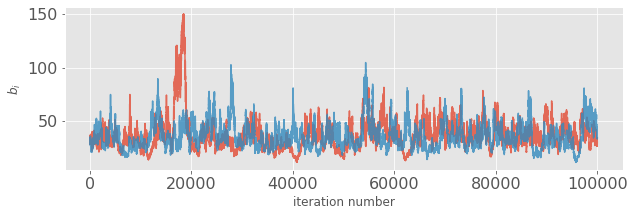

In [4]:
plt.figure(figsize=(10,3))
n=5
plt.plot(traces1['bandwidths'][:, n], lw=1.5, alpha=.8);
plt.plot(traces2['bandwidths'][:, n], lw=1.5, alpha=.8);
plt.xlabel('iteration number')
plt.ylabel('$b_{i}$');
plt.savefig('../writeup/bandwidths.png', dpi=300, bbox_inches='tight')

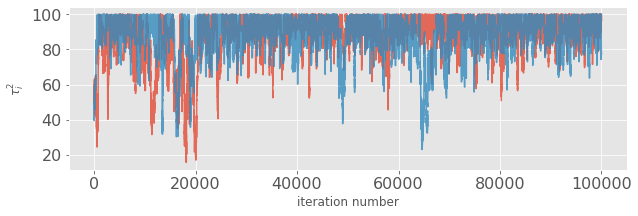

In [5]:
plt.figure(figsize=(10,3))
n=5
plt.plot(traces1['tau_sq_1s'][:, n], lw=1.5, alpha=.8);
plt.plot(traces2['tau_sq_1s'][:, n], lw=1.5, alpha=.8);
plt.xlabel('iteration number')
plt.ylabel(r'$\tau^2_{i}$');
plt.savefig('../writeup/tau.png', dpi=300, bbox_inches='tight')

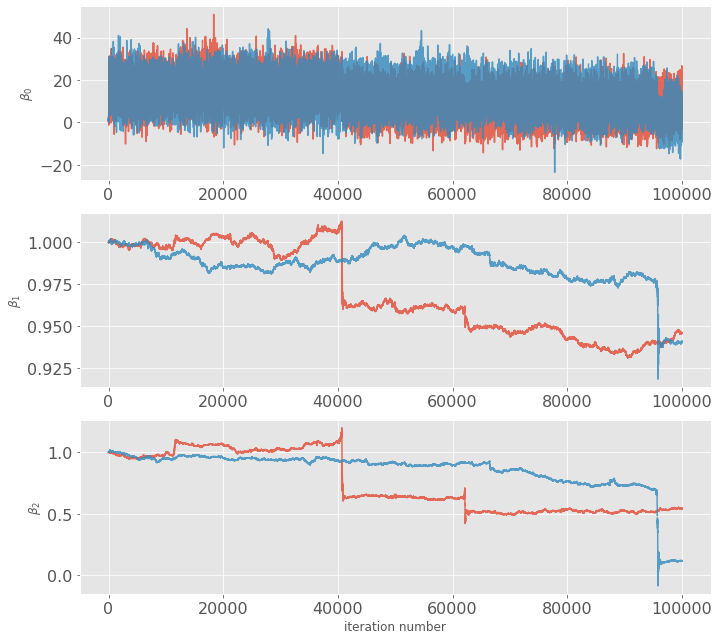

In [6]:
plt.figure(figsize=(10,9))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(traces1['betas'][:,i, n], lw=1.5, alpha=.8)
    plt.plot(traces2['betas'][:,i, n], lw=1.5, alpha=.8)
    plt.ylabel(fr'$\beta_{i}$')
    
plt.xlabel('iteration number')
    
        
plt.tight_layout()
plt.savefig('../writeup/betas_traces.png', dpi=300, bbox_inches='tight')

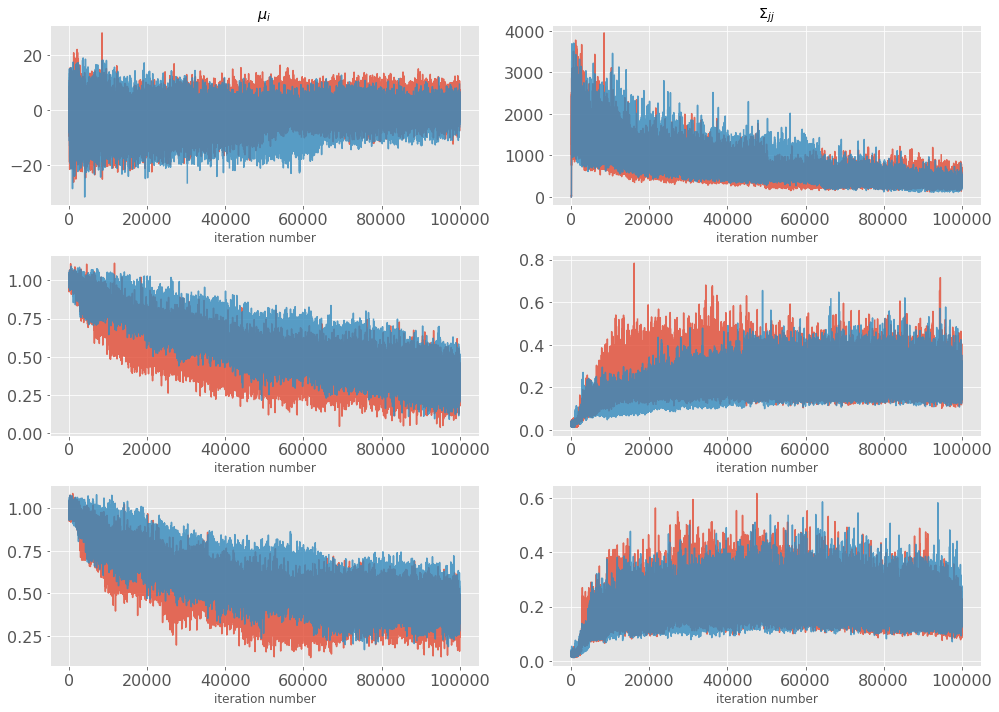

In [7]:
plt.figure(figsize=(14,10))
for i in range(3):
    plt.subplot(3, 2, 2*i+1)
    if i == 0:
        plt.title(r'$\mu_i$')
    plt.plot(traces1['mu'][:,i], lw=1.5, alpha=.8)
    plt.plot(traces2['mu'][:,i], lw=1.5, alpha=.8)
    plt.xlabel('iteration number')
    plt.subplot(3, 2, 2*i+2)
    plt.plot(traces1['taus'][:,i], lw=1.5, alpha=.8)
    plt.plot(traces2['taus'][:,i], lw=1.5, alpha=.8)
    
    plt.xlabel('iteration number')
    if i == 0:
        plt.title(r'$\Sigma_{jj}$')
        
plt.tight_layout()
plt.savefig('../writeup/traces_all.png', dpi=300, bbox_inches='tight')

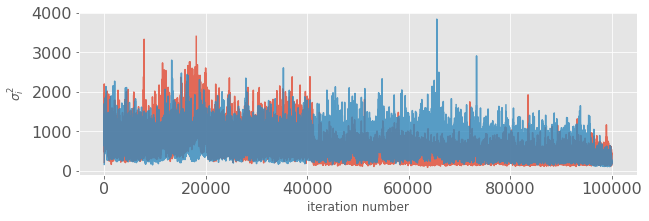

In [8]:
plt.figure(figsize=(10,3))
n=5
plt.plot(traces1['sigmas_squared'][:, n], lw=1.5, alpha=.8);
plt.plot(traces2['sigmas_squared'][:, n], lw=1.5, alpha=.8);
plt.xlabel('iteration number')
plt.ylabel('$\sigma^2_{i}$');
plt.savefig('../writeup/sigma.png', dpi=300, bbox_inches='tight')

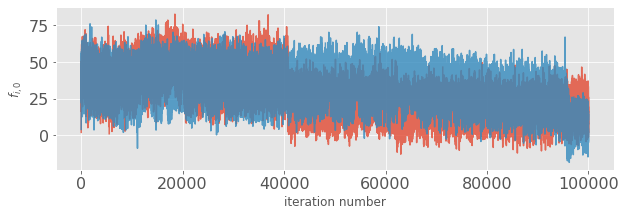

In [9]:
plt.figure(figsize=(10,3))
n=5
plt.plot(traces1['f'][n][0, :], lw=1.5, alpha=.8);
plt.plot(traces2['f'][n][0, :], lw=1.5, alpha=.8);
plt.xlabel('iteration number')
plt.ylabel('$f_{i,0}$');
plt.savefig('../writeup/f.png', dpi=300, bbox_inches='tight')

In [10]:
traces_mu = np.concatenate([traces1['mu'][50000:], traces2['mu'][80000:]])
traces_sig = np.concatenate([traces1['taus'][50000:], traces2['taus'][80000:]])

In [11]:
gb = basic_gibbs.GibbsSampler(X_depts, y_depts, n_iter=10000, burn=1000)
gb.fit()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:24<00:00, 69.44it/s]


In [12]:
all_traces = [traces1, traces2]

In [13]:
def calculate_gelman_rubin_stat(traces):
    L = len(four_traces[0])
    J = len(traces)
    chain_means = [np.nanmean(trace) for trace in four_traces]
    grand_mean = np.mean(chain_means)
    B = L*np.var(chain_means, ddof=1)
    within_var = [np.nanvar(trace, ddof=1) for trace in four_traces]
    W = np.mean(within_var)
    return (((L-1)/L * W) + 1/L * B)/W

In [14]:
four_traces = [trace['tau_sq_1s'][5000:,5] for trace in all_traces]
calculate_gelman_rubin_stat(four_traces)


1.0001614907797098